# Measure skew-spectra of galaxies in redshift space #

In [1]:
from __future__ import print_function, division


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from nbodykit import style

import matplotlib.pyplot as plt
import numpy as np
import os

from lsstools.cosmo_model import CosmoModel
from lsstools.gen_cosmo_fcns import calc_f_log_growth_rate, generate_calc_Da
from lsstools.model_spec import get_trf_spec_from_list
from lsstools.paint_utils import mass_weighted_paint_cat_to_delta
from lsstools.results_db import retrieve_pickles
from lsstools.results_db.io import Pickler
from perr.path_utils import get_in_path
from lsstools.nbkit03_utils import get_csum, get_csqsum, apply_smoothing, catalog_persist, get_cstats_string, linear_rescale_fac, get_crms,convert_nbk_cat_to_np_array
from perr_private.model_target_pair import ModelTargetPair, Model, Target
from lsstools.sim_galaxy_catalog_creator import SimGalaxyCatalogCreator, PTChallengeGalaxiesFromRockstarHalos
from perr_private.read_utils import readout_mesh_at_cat_pos


#from nbodykit.lab import ArrayCatalog, BigFileMesh


plt.style.use(style.notebook)
colors = [d['color'] for d in style.notebook['axes.prop_cycle']]

## Global params ##

In [2]:
# path
sim_seed = 400
basedir = '/Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000%d-01536-500.0-wig/' % sim_seed
sim_scale_factor = 0.625

# cosmology of ms_gadget sims (to compute D_lin(z))
# omega_m = 0.307494
# omega_bh2 = 0.022300
# omega_ch2 = 0.118800
# h = math.sqrt((omega_bh2 + omega_ch2) / omega_m) = 0.6774
cosmo_params = dict(Om_m=0.307494,
                   Om_L=1.0 - 0.307494,
                   Om_K=0.0,
                   Om_r=0.0,
                   h0=0.6774)

f_log_growth = np.sqrt(0.61826)



# Smoothings in lagrangian space, in Mpc/h
Rsmooth_density_to_shift = 0.0   # 0.0 before 30/3/2020
Rsmooth_displacement_source = 0.23   # 0.23 before 30/3/2020

Ngrid = 512

# Options for shifted field
ShiftedFieldsNp = 1536
ShiftedFieldsNmesh = 1536


# avg or sum. Should use avg to get correct velocity model.
PsiDot_weighted_CIC_mode = 'avg'


# Below, 'D' stands for RSD displacement in Mpc/h: D=v/(aH)=f*PsiDot.
tex_names = {}

## Targets
# DM subsample
DM_D0 = Target(
    name='DM_D0',
    in_fname=os.path.join(basedir, 'snap_%.4f_sub_sr0.0015_ssseed40400.bigfile' % sim_scale_factor),
    position_column='Position',
    val_column='Velocity',
    val_component=0,
    rescale_factor='RSDFactor'
)




# PT Challenge galaxies from rockstar halos. Rockstar gives core positions and velocities.
# Units: 1/(aH) = 1./(a * H0*np.sqrt(Om_m/a**3+Om_L)) * (H0/100.) in Mpc/h / (km/s).
# For ms_gadget, get 1/(aH) = 0.01145196 Mpc/h/(km/s) = 0.0183231*0.6250 Mpc/h/(km/s).
# Note that MP-Gadget files have RSDFactor=1/(a^2H)=0.0183231 for a=0.6250 b/c they use a^2\dot x for Velocity.
assert sim_scale_factor == 0.625
gal_ptchall_D0 = Target(
    name='gal_ptchall_D0',
    in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.parents.bigfile' % sim_scale_factor),
    position_column='Position',
    val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
    val_component=0,
    rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v. 
    RSDFactor=0.01145196, # used internally to get redshift space positions if needed (e.g. for cylinder cuts)
    cuts=[PTChallengeGalaxiesFromRockstarHalos(
            log10M_column='log10Mvir', log10Mmin=12.97, sigma_log10M=0.35, RSD=False)
         ]
    )

# subbox of PT challenge galaxies, x component
assert sim_scale_factor == 0.625
gal_ptchall_subbox_D0 = Target(
    name='gal_ptchall_D0',
    in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.parents.bigfile' % sim_scale_factor),
    position_column='Position',
    val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
    val_component=0,
    rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v. 
    RSDFactor=0.01145196, # used internally to get redshift space positions if needed
    cuts=[PTChallengeGalaxiesFromRockstarHalos(
            log10M_column='log10Mvir', log10Mmin=12.97, sigma_log10M=0.35, RSD=False),
          ('Position', 'max', [100.,100.,100.])
         ]
    )

# subbox of PT challenge galaxies, apply RSD to position (TEST)
LOS = np.array([1,0,0])
assert sim_scale_factor == 0.625
gal_ptchall_with_RSD = Target(
    name='gal_ptchall_with_RSD',
    in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.parents.bigfile' % sim_scale_factor),
    position_column='Position',
    velocity_column='Velocity', 
    apply_RSD_to_position=True,
    RSD_los=LOS,
    RSDFactor=0.01145196,
    #val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
    #val_component=0,
    #rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v. 
    cuts=[PTChallengeGalaxiesFromRockstarHalos(
            log10M_column='log10Mvir', log10Mmin=12.97, sigma_log10M=0.35, RSD=False),
          #('Position', 'max', [100.,100.,20.])
         ]
    )

# subbox of PT challenge galaxies, y component
assert sim_scale_factor == 0.625
gal_ptchall_subbox_D1 = Target(
    name='gal_ptchall_D1',
    in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.parents.bigfile' % sim_scale_factor),
    position_column='Position',
    val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
    val_component=1,
    rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v. 
    cuts=[PTChallengeGalaxiesFromRockstarHalos(
            log10M_column='log10Mvir', log10Mmin=12.97, sigma_log10M=0.35, RSD=False),
          ('Position', 'max', [500.,500.,20.])
         ]
    )


In [3]:
### Models

# 1st order PsiDot shifted by linear Psi
s = ('IC_LinearMesh_PsiDot1_0_intR0.00_extR%.2f_SHIFTEDBY_'
     'IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICavg' % (
         Rsmooth_density_to_shift,
         Rsmooth_displacement_source,
         sim_scale_factor,
         ShiftedFieldsNp, 
         ShiftedFieldsNmesh,
         Ngrid))
PsiDot1_D0 = Model(
    name='PsiDot1_D0',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='velocity',
    filters=None,
    readout_window='cic')

# y direction
s = ('IC_LinearMesh_PsiDot1_1_intR0.00_extR%.2f_SHIFTEDBY_'
     'IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICavg' % (
         Rsmooth_density_to_shift,
         Rsmooth_displacement_source,
         sim_scale_factor,
         ShiftedFieldsNp, 
         ShiftedFieldsNmesh,
         Ngrid))
PsiDot1_D1 = Model(
    name='PsiDot1_D1',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='velocity',
    filters=None,
    readout_window='cic')


# 2nd order PsiDot shifted by 2nd order Psi
s = ('IC_LinearMesh_PsiDot2_0_intR0.00_extR%.2f_SHIFTEDBY_'
     'Psi2LPT_IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICavg' % (
         Rsmooth_density_to_shift,
         Rsmooth_displacement_source,
         sim_scale_factor,
         ShiftedFieldsNp, 
         ShiftedFieldsNmesh,
         Ngrid))
PsiDot2_D0 = Model(
    name='PsiDot2_D0',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='velocity',
    filters=None,
    readout_window='cic')

# y direction
s = ('IC_LinearMesh_PsiDot2_1_intR0.00_extR%.2f_SHIFTEDBY_'
     'Psi2LPT_IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICavg' % (
         Rsmooth_density_to_shift,
         Rsmooth_displacement_source,
         sim_scale_factor,
         ShiftedFieldsNp, 
         ShiftedFieldsNmesh,
         Ngrid))
PsiDot2_D1 = Model(
    name='PsiDot2_D1',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='velocity',
    filters=None,
    readout_window='cic')


# 2nd order PsiDot shifted by 1st order Psi
s = ('IC_LinearMesh_PsiDot2_0_intR0.00_extR%.2f_SHIFTEDBY_'
     'IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICavg' % (
         Rsmooth_density_to_shift,
         Rsmooth_displacement_source,
         sim_scale_factor,
         ShiftedFieldsNp, 
         ShiftedFieldsNmesh,
         Ngrid))
PsiDot2_shiftedbyPsi1_D0 = Model(
    name='PsiDot2_shiftedbyPsi1_D0',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='velocity',
    filters=None,
    readout_window='cic')

# y direction
s = ('IC_LinearMesh_PsiDot2_1_intR0.00_extR%.2f_SHIFTEDBY_'
     'IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICavg' % (
         Rsmooth_density_to_shift,
         Rsmooth_displacement_source,
         sim_scale_factor,
         ShiftedFieldsNp, 
         ShiftedFieldsNmesh,
         Ngrid))
PsiDot2_shiftedbyPsi1_D1 = Model(
    name='PsiDot2_shiftedbyPsi1_D1',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='velocity',
    filters=None,
    readout_window='cic')


# k/k^2 deltaZ, x direction
def k0ovksq_filter_fcn(k, v, d=0):
    k2 = sum(ki**2 for ki in k)
    return np.where(k2 == 0.0, 0*v, 1j*k[d] * v / (k2))

s = '1_intR0.00_extR%.2f_SHIFTEDBY_IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICsum' % (
        Rsmooth_density_to_shift, Rsmooth_displacement_source, sim_scale_factor,
        ShiftedFieldsNp, ShiftedFieldsNmesh, Ngrid)
deltaZ_D0 = Model(
    name='deltaZ_D0',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    #read_mode='density',
    read_mode='delta from 1+delta',
    filters=[k0ovksq_filter_fcn],
    readout_window='cic')

# k/k^2 deltaZ, y direction
def k1ovksq_filter_fcn(k, v, d=1):
    k2 = sum(ki**2 for ki in k)
    return np.where(k2 == 0.0, 0*v, 1j*k[d] * v / (k2))

s = '1_intR0.00_extR%.2f_SHIFTEDBY_IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICsum' % (
        Rsmooth_density_to_shift, Rsmooth_displacement_source, sim_scale_factor,
        ShiftedFieldsNp, ShiftedFieldsNmesh, Ngrid)
deltaZ_D1 = Model(
    name='deltaZ_D1',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    read_mode='delta from 1+delta',
    filters=[k1ovksq_filter_fcn],
    readout_window='cic')


# k/k^2 delta2LPT, x direction
def k0ovksq_filter_fcn(k, v, d=0):
    k2 = sum(ki**2 for ki in k)
    return np.where(k2 == 0.0, 0*v, 1j*k[d] * v / (k2))

s = '1_intR0.00_extR%.2f_SHIFTEDBY_Psi2LPT_IC_LinearMeshR%.2f_a%.4f_Np%d_Nm%d_Ng%d_CICsum' % (
        Rsmooth_density_to_shift, Rsmooth_displacement_source, sim_scale_factor,
        ShiftedFieldsNp, ShiftedFieldsNmesh, Ngrid)
delta2LPT_D0 = Model(
    name='delta2LPT_D0',
    in_fname=os.path.join(basedir, s),
    rescale_factor=f_log_growth,
    #read_mode='density',
    read_mode='delta from 2+delta',
    filters=[k0ovksq_filter_fcn],
    readout_window='cic')


# k/k^2 delta_lin
z_rescalefac = linear_rescale_fac(current_scale_factor=1.0,
                                  desired_scale_factor=sim_scale_factor,
                                  cosmo_params=cosmo_params)
deltalin_D0 = Model(
    name='deltalin_D0',
    in_fname=os.path.join(basedir, 'IC_LinearMesh_z0_Ng%d' % Ngrid),
    rescale_factor=f_log_growth*z_rescalefac,
    read_mode='density',
    filters=[k0ovksq_filter_fcn],
    readout_window='cic')
deltalin_D1 = Model(
    name='deltalin_D1',
    in_fname=os.path.join(basedir, 'IC_LinearMesh_z0_Ng%d' % Ngrid),
    rescale_factor=f_log_growth*z_rescalefac,
    read_mode='density',
    filters=[k1ovksq_filter_fcn],
    readout_window='cic')

deltalin = Model(
    name='deltalin',
    in_fname=os.path.join(basedir, 'IC_LinearMesh_z0_Ng%d' % Ngrid),
    rescale_factor=z_rescalefac,
    read_mode='delta from 1+delta',
    filters=None,
    readout_window='cic')


## Get catalog in redshift space ##

In [4]:
# get the catalog
target = gal_ptchall_with_RSD

BoxSize = np.array([500.,500.,500.])

cat = target.get_catalog(keep_all_columns=True)
print(cat.attrs)

# add redshift space positions, assuming LOS is in x direction
#LOS = np.array([1,0,0])
#cat['RSDPosition'] = cat['Position'] + cat['Velocity']*mtp.target.RSDFactor * LOS

print(cat.columns)  
cat = catalog_persist(cat, columns=['ID','PID','Position','Velocity',
                                    'log10Mvir'])
print(cat.columns)





Read /Users/mschmittfull/scratch_data/lss/ms_gadget/run4/00000400-01536-500.0-wig/snap_0.6250.gadget3/rockstar_out_0.list.parents.bigfile
Apply RSD
Nhalos: 10934998
Ngalaxies: 56095
Galaxy mass:  rms, min, mean, max: 0.364419 11.8669 13.1295 15.238
Cuts removed -99.487% of objects
{'rockstar_header': array(u'#ID DescID Mvir Vmax Vrms Rvir Rs Np X Y Z VX VY VZ JX JY JZ Spin rs_klypin Mvir_all M200b M200c M500c M2500c Xoff Voff spin_bullock b_to_a c_to_a A[x] A[y] A[z] b_to_a(500c) c_to_a(500c) A[x](500c) A[y](500c) A[z](500c) T/|U| M_pe_Behroozi M_pe_Diemer Halfmass_Radius PID\n#a = 0.625000\n#Om = 0.307494; Ol = 0.692506; h = 0.677400\n#FOF linking length: 0.280000\n#Unbound Threshold: 0.500000; FOF Refinement Threshold: 0.700000\n#Particle mass: 2.94384e+09 Msun/h\n#Box size: 500.000000 Mpc/h\n#Force resolution assumed: 0.01085 Mpc/h\n#Units: Masses in Msun / h\n#Units: Positions in Mpc / h (comoving)\n#Units: Velocities in km / s (physical, peculiar)\n#Units: Halo Distances, Lengths,

In [5]:
cat.attrs

{'rockstar_header': array(u'#ID DescID Mvir Vmax Vrms Rvir Rs Np X Y Z VX VY VZ JX JY JZ Spin rs_klypin Mvir_all M200b M200c M500c M2500c Xoff Voff spin_bullock b_to_a c_to_a A[x] A[y] A[z] b_to_a(500c) c_to_a(500c) A[x](500c) A[y](500c) A[z](500c) T/|U| M_pe_Behroozi M_pe_Diemer Halfmass_Radius PID\n#a = 0.625000\n#Om = 0.307494; Ol = 0.692506; h = 0.677400\n#FOF linking length: 0.280000\n#Unbound Threshold: 0.500000; FOF Refinement Threshold: 0.700000\n#Particle mass: 2.94384e+09 Msun/h\n#Box size: 500.000000 Mpc/h\n#Force resolution assumed: 0.01085 Mpc/h\n#Units: Masses in Msun / h\n#Units: Positions in Mpc / h (comoving)\n#Units: Velocities in km / s (physical, peculiar)\n#Units: Halo Distances, Lengths, and Radii in kpc / h (comoving)\n#Units: Angular Momenta in (Msun/h) * (Mpc/h) * km/s (physical)\n#Units: Spins are dimensionless\n#Np is an internal debugging quantity.\n#Rockstar Version: 0.99.9-RC3+\n',
       dtype='<U878')}

## Calculate power spectrum multipoles ##

In [6]:
from nbodykit.lab import FFTPower, FieldMesh
def calc_power(mesh, second=None, mode='1d', k_bin_width=1.0, verbose=False, los=None, poles=None):
    BoxSize = mesh.attrs['BoxSize']
    assert BoxSize[0] == BoxSize[1]
    assert BoxSize[0] == BoxSize[2]
    boxsize = BoxSize[0]
    dk = 2.0 * np.pi / boxsize * k_bin_width
    kmin = 2.0 * np.pi / boxsize / 2.0

    if mode == '1d':
        res = FFTPower(first=mesh,
                        second=second,
                        mode=mode,
                        dk=dk,
                        kmin=kmin)
    elif mode == '2d':
        if poles is None:
            poles = [0,2,4]
        res = FFTPower(first=mesh,
                            second=second,
                            mode=mode,
                            dk=dk,
                            kmin=kmin,
                            poles=poles,
                            Nmu=5,
                            los=los)
    else:
        raise Exception("Mode not implemented: %s" % mode)

    return res

In [7]:
## Compute power spectrum 
Nmesh = 256

# original catalog in redshift space
#RSDcat = catalog_persist(cat, columns=['RSDPosition', 'residual_D0'])
#RSDcat['Position'] = RSDcat['RSDPosition']
#del cat

print('# objects: Original: %d' % (cat.csize))

delta_mesh = FieldMesh(cat.to_mesh(Nmesh=Nmesh, BoxSize=BoxSize, 
                      window='cic', interlaced=False, compensated=False).compute()-1)
print('Mesh: ', get_cstats_string(delta_mesh.compute()))



Pdd = calc_power(delta_mesh, los=LOS, mode='2d', poles=[0,2,4,6])



# objects: Original: 56095
Mesh:  rms, min, mean, max: 9.90593 -1 3.39423e-09 603.067


In [8]:
Pdd.attrs

{'BoxSize': array([500., 500., 500.]),
 'Lx': 500.0,
 'Ly': 500.0,
 'Lz': 500.0,
 'N1': 0,
 'N2': 0,
 'Nmesh': array([256, 256, 256]),
 'Nmu': 5,
 'dk': 0.012566370614359173,
 'kmin': 0.006283185307179587,
 'los': array([1, 0, 0]),
 'mode': '2d',
 'poles': [0, 2, 4, 6],
 'shotnoise': 0,
 'volume': 125000000.0}

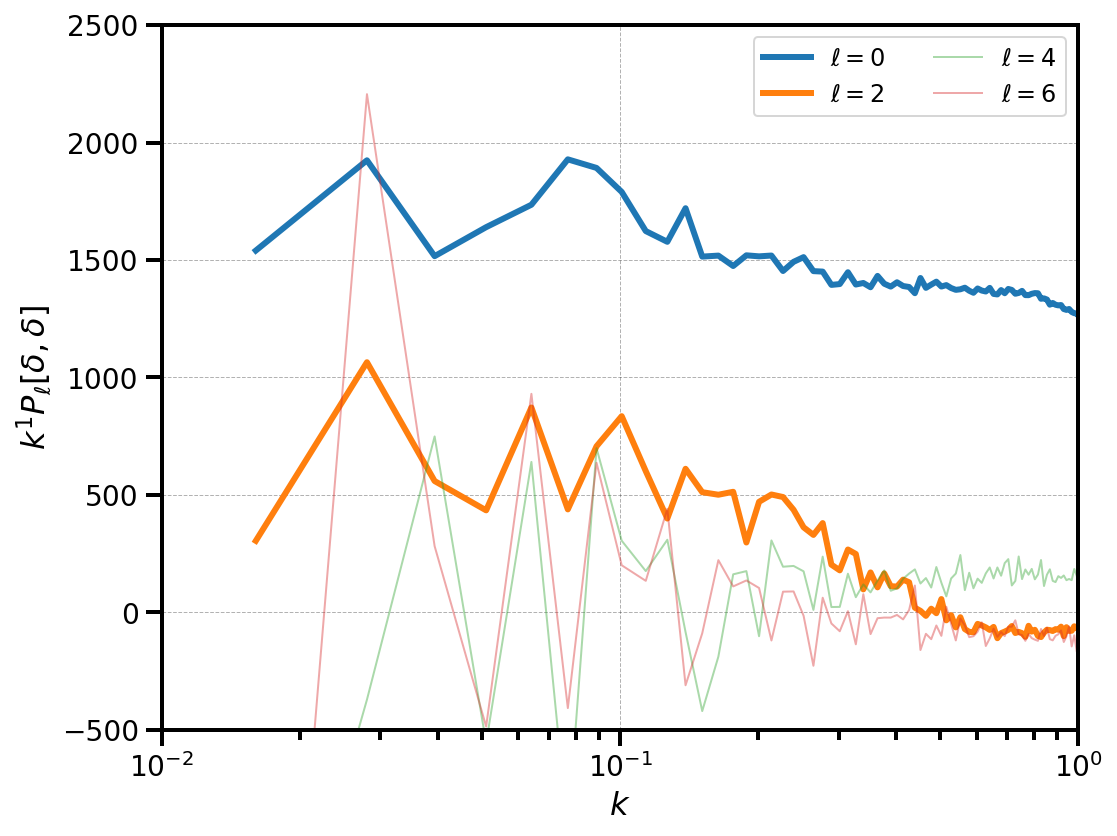

In [9]:
# plot power spectrum of density
plt.figure(figsize=(8,6))
kvec = Pdd.poles['k']
kpow = 1

for ell in Pdd.attrs['poles']:
    if ell>2:
        lw, alpha = 1,0.4
    else:
        lw, alpha = 3,1
    plt.semilogx(kvec, (kvec**kpow*Pdd.poles['power_%d'%ell].real), label=r'$\ell=%d$'%ell,
            lw=lw, alpha=alpha)

plt.xlabel(r'$k$')
ax = plt.gca()
ax.set_xlim((0.01,1))
ax.legend(loc='best', ncol=2, fontsize=12)
ax.set_ylabel(r'$k^%dP_\ell[\delta,\delta]$' % kpow)
plt.tight_layout()
plt.ylim((-500,2500));


## Compute skew spectra ##

In [10]:
delta2 = FieldMesh((delta_mesh.compute())**2)
P_delta2_delta = calc_power(delta2, second=delta_mesh, los=LOS, mode='2d', poles=[0,2,4,6])

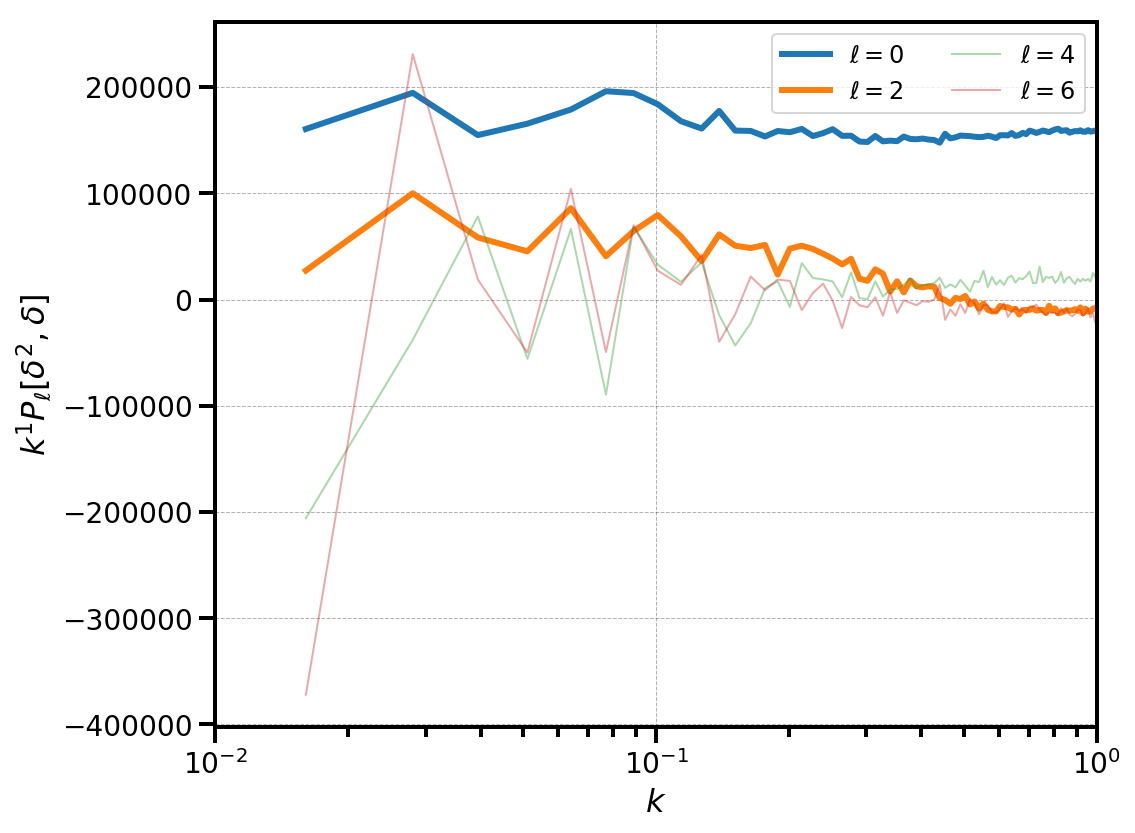

In [11]:
# plot power spectrum 
plt.figure(figsize=(8,6))
kvec = P_delta2_delta.poles['k']
kpow = 1

for ell in P_delta2_delta.attrs['poles']:
    if ell>2:
        lw, alpha = 1,0.4
    else:
        lw, alpha = 3,1
    plt.semilogx(kvec, (kvec**kpow*P_delta2_delta.poles['power_%d'%ell].real), label=r'$\ell=%d$'%ell,
            lw=lw, alpha=alpha)

plt.xlabel(r'$k$')
ax = plt.gca()
ax.set_xlim((0.01,1))
ax.legend(loc='best', ncol=2, fontsize=12)
ax.set_ylabel(r'$k^%dP_\ell[\delta^2,\delta]$' % kpow)
plt.tight_layout()
#plt.ylim((-500,2500));



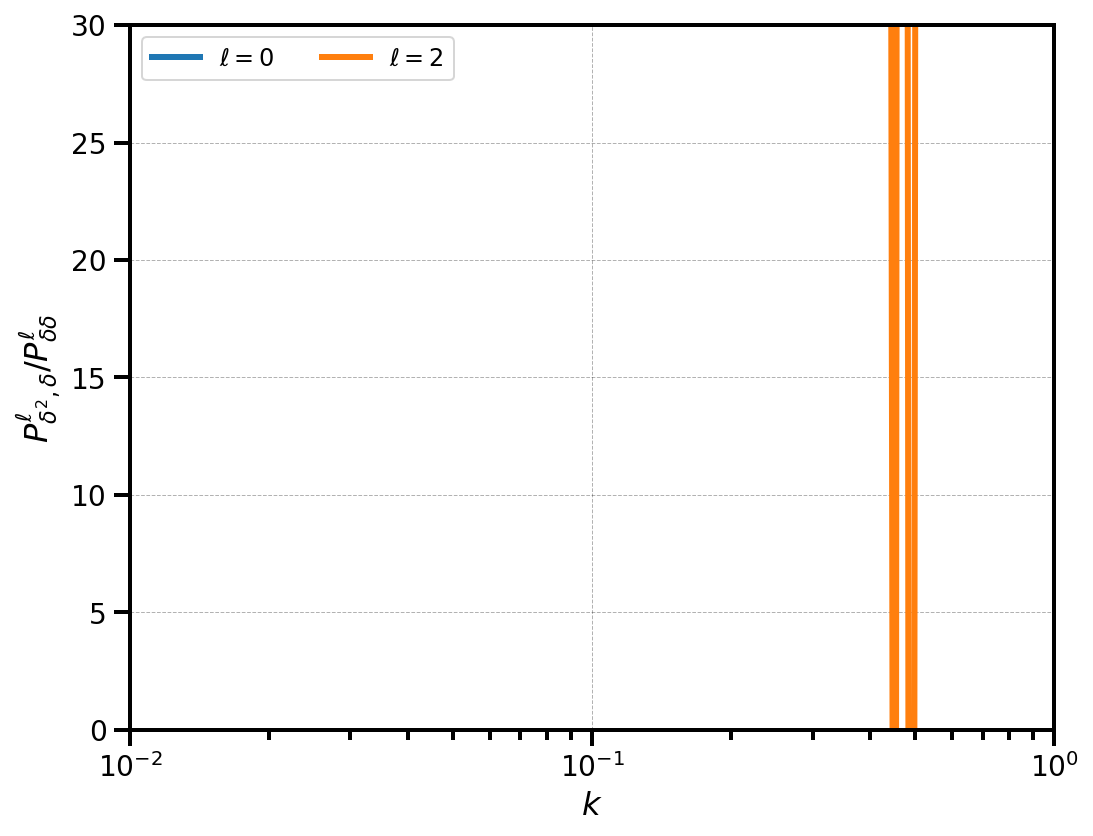

In [12]:
# plot P_{d2,d}/P_dd
plt.figure(figsize=(8,6))
kvec = P_delta2_delta.poles['k']
kpow = 1

for ell in [0,2]:
    if ell>2:
        lw, alpha = 1,0.4
    else:
        lw, alpha = 3,1
    plt.semilogx(kvec, P_delta2_delta.poles['power_%d'%ell].real/Pdd.poles['power_%d'%ell].real,
                 label=r'$\ell=%d$'%ell,
            lw=lw, alpha=alpha)

plt.xlabel(r'$k$')
ax = plt.gca()
ax.set_xlim((0.01,1))
ax.legend(loc='best', ncol=2, fontsize=12)
ax.set_ylabel(r'$P^\ell_{\delta^2,\delta}/P^\ell_{\delta\delta}$')
plt.tight_layout()
plt.ylim((0,30));




In [13]:
from skewspec import smoothing
from skewspec.skew_spectrum import SkewSpectrum, compute_dnm, compute_dnm_dnmprime



In [14]:
# apply smoothing
Rsmooth = 20.
smoothers = [smoothing.GaussianSmoother(R=Rsmooth)]
delta_mesh_smoothed = FieldMesh(delta_mesh.compute(mode='real'))
for smoother in smoothers:
    delta_mesh_smoothed = smoother.apply_smoothing(delta_mesh_smoothed)
    
print('delta: ', get_cstats_string(delta_mesh.compute(mode='real')))
print('delta smoothed: ', get_cstats_string(delta_mesh_smoothed.compute(mode='real')))

delta:  rms, min, mean, max: 9.90593 -1 3.39423e-09 603.067
delta smoothed:  rms, min, mean, max: 0.323213 -0.72157 1.32059e-09 1.7353


In [15]:
test_quad_field = compute_dnm_dnmprime(delta_mesh_smoothed, n=0, nprime=-2, m=[0,0,0], mprime=[1,0,0])

d_0^000:  rms, min, mean, max: 0.323213 -0.72157 1.32059e-09 1.7353
d_-2^100:  rms, min, mean, max: 5.11013 -17.1929 1.03487e-10 18.9186
d_0^000:  rms, min, mean, max: 0.323213 -0.72157 1.32059e-09 1.7353
d_-2^100 prime:  rms, min, mean, max: 5.11013 -17.1929 1.03487e-10 18.9186
d*dprime:  rms, min, mean, max: 1.6969 -14.0749 -0.262474 12.7337


In [16]:
S2 = SkewSpectrum(name='S2', LOS=LOS)
S3 = SkewSpectrum(name='S3', nprime=-2, mprime=LOS, mprimeprime=LOS, LOS=LOS)
S5 = SkewSpectrum(name='S5', nprime=-2, mprime=2*LOS, LOS=LOS)
S6a = SkewSpectrum(name='S6a', nprime=-4, mprime=3*LOS,mprimeprime=LOS, LOS=LOS)
S6b = SkewSpectrum(name='S6b', prefactor=2.0, n=-2, nprime=-2, m=LOS, mprime=2*LOS, mprimeprime=LOS, LOS=LOS)
S8 = SkewSpectrum(name='S8', n=-2, nprime=-2, m=2*LOS, mprime=2*LOS, LOS=LOS)
S9a = SkewSpectrum(name='S9a', n=-4, nprime=-2, m=4*LOS, mprime=LOS, mprimeprime=LOS, LOS=LOS)
S9b = SkewSpectrum(name='S9b', prefactor=2.0, n=-4, nprime=-2, m=3*LOS, mprime=2*LOS, mprimeprime=LOS, LOS=LOS)
S11 = SkewSpectrum(name='S11', n=-4, nprime=-4, m=3*LOS, mprime=4*LOS, mprimeprime=LOS, LOS=LOS)

In [17]:
power_kwargs={'mode': '2d', 'poles':[0,2]}
skew_spectra = [S2,S3,S5,S6a,S6b, S8, S9a, S9b, S11]
for skew_spec in skew_spectra:
    # compute and store in skew_spec.Pskew
    skew_spec.compute_from_mesh(mesh=delta_mesh_smoothed, third_mesh=delta_mesh, power_kwargs=power_kwargs)

d_0^000:  rms, min, mean, max: 0.323213 -0.72157 1.32059e-09 1.7353
d_0^000:  rms, min, mean, max: 0.323213 -0.72157 1.32059e-09 1.7353
d_0^000:  rms, min, mean, max: 0.323213 -0.72157 1.32059e-09 1.7353
d_0^000 prime:  rms, min, mean, max: 0.323213 -0.72157 1.32059e-09 1.7353
d*dprime:  rms, min, mean, max: 0.162443 1.38778e-15 0.104467 3.01126
d_0^000:  rms, min, mean, max: 9.90593 -1.00006 8.22183e-09 603.067
d_0^000:  rms, min, mean, max: 0.323213 -0.72157 1.32059e-09 1.7353
d_-2^100:  rms, min, mean, max: 5.11013 -17.1929 1.03487e-10 18.9186
d_0^000:  rms, min, mean, max: 0.323213 -0.72157 1.32059e-09 1.7353
d_-2^100 prime:  rms, min, mean, max: 5.11013 -17.1929 1.03487e-10 18.9186
d*dprime:  rms, min, mean, max: 1.6969 -14.0749 -0.262474 12.7337
d_0^100:  rms, min, mean, max: 7.31434 -198.087 1.844e-10 199.147
d_0^000:  rms, min, mean, max: 0.323213 -0.72157 1.32059e-09 1.7353
d_-2^200:  rms, min, mean, max: 0.157632 -0.458141 -1.26092e-08 0.674648
d_0^000:  rms, min, mean, max: 

Made ../pdf/skew2_R20.0_Ng256.pdf


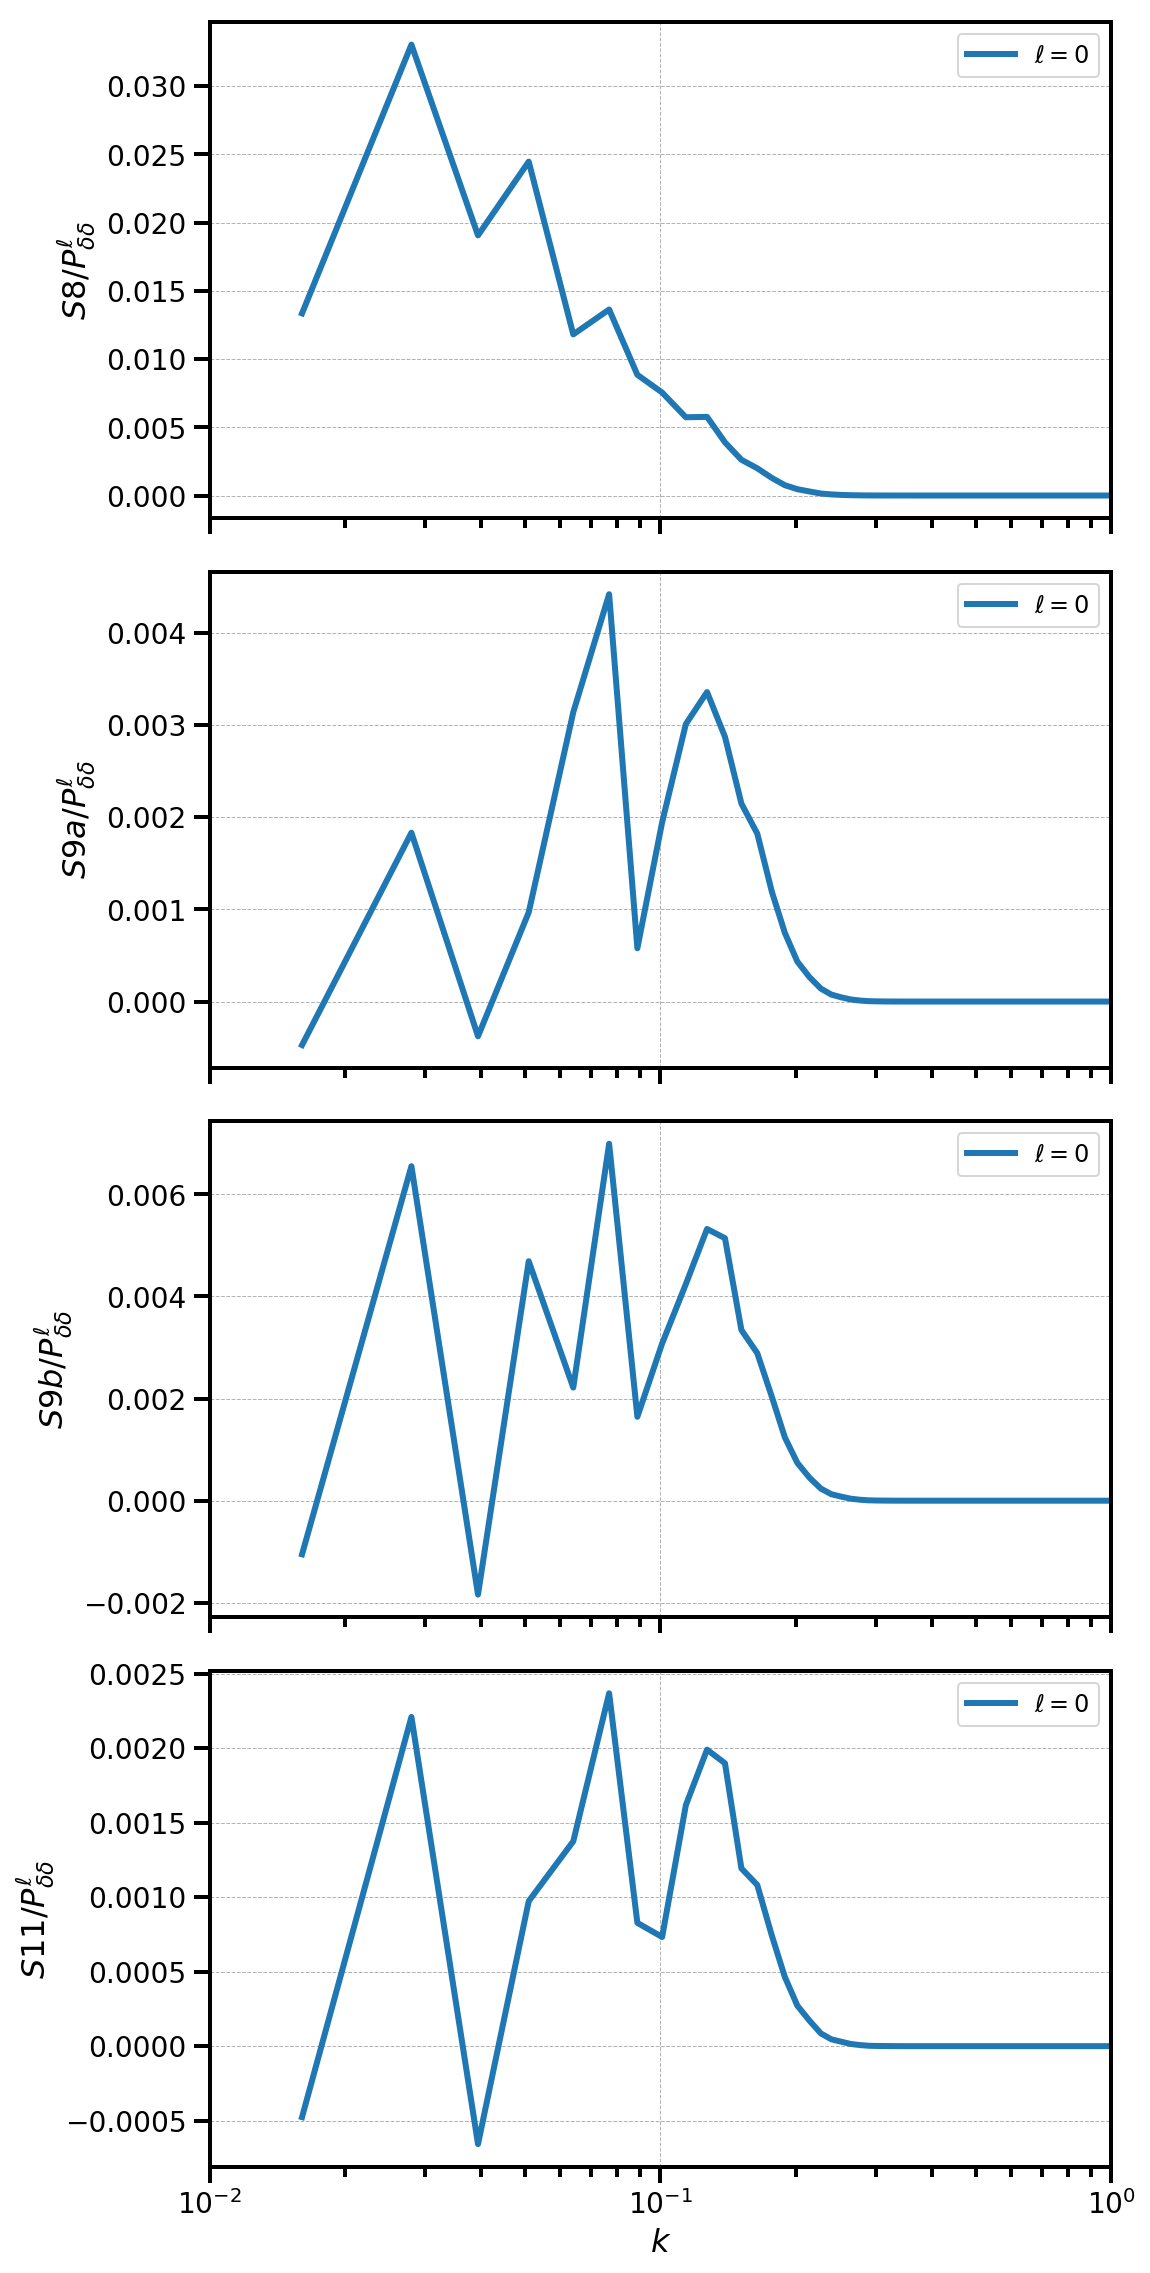

In [19]:
# plot Pskew/P_dd
plt_spectra = skew_spectra[5:]

fig, axarr = plt.subplots(len(plt_spectra), 1, figsize=(8,4*len(plt_spectra)),
                         sharex=True)

kvec = Pdd.poles['k']

for i,skew_spec in enumerate(plt_spectra):
    ax = axarr[i]

    for ell in [0]:
        if ell>2:
            lw, alpha = 1,0.4
        else:
            lw, alpha = 3,1
        ax.semilogx(kvec, skew_spec.Pskew.poles['power_%d'%ell].real/Pdd.poles['power_%d'%ell].real,
                     label=r'$\ell=%d$'%ell,
                lw=lw, alpha=alpha)

    ax.set_xlim((0.01,1))
    ax.legend(loc='best', ncol=2, fontsize=12)
    ax.set_ylabel(r'$%s/P^\ell_{\delta\delta}$' % skew_spec.name)
axarr[-1].set_xlabel(r'$k$') 

#axarr[0].set_ylim((0,50))
#axarr[1].set_ylim((-2,2))

plt.tight_layout()

fname = '../pdf/skew2_R%.1f_Ng%d.pdf' % (Rsmooth,Nmesh)
plt.savefig(fname)
print('Made %s' % fname)